# Estimating infection risk from serology samples

This tutorial gives a worked example of how to estimate infection risk from serology samples.  The tutorial is organized as follows

1. The simulation of a data set with longitudinal and cross-sectional serology samples. These data are then used with the methods developed in Pepin et al. (2017, *Ecology Letters*) and extended in this manuscript to estimate time of infection (TOI) for all seropositive samples.
2. The estimated TOI for seropositive hosts is then used to back-infer seasonal infection risk.

In [2]:
import survival as surv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import scipy.stats as stats
plt.rcParams['figure.facecolor'] = "white"

## Estimating time of infection from serology samples

### Simulate antibody lab data

The theoretical antibody curve is given by 

$$\begin{equation}
y = g(\tau; \boldsymbol{\theta}) = 
\begin{cases}
  X_1 & \text{ if } \tau < A \\
  X_1 + X_2\frac{\tau - A}{B} + \frac{r + rd(B - (\tau - A))}{B d^2} - \frac{r + rdB}{Bd^2}e^{-d(\tau - A)} & \text{ if } A \leq \tau < A + B  \\
  X_1 + X_2 + \frac{re^{dB} - r - drB}{Bd^2} e^{-d(\tau - A)} & \text{ if } \tau \geq A + B
\end{cases}
\end{equation}$$

$X_1$ gives the baseline level of antibodies prior to exposure, $A$ gives the initial lag between exposure and antibody production, $r$ gives the antibody production rate, $d$ gives the antibody decay rate, $B$ gives the period of antibody production in response to infection, and $X_1 + X_2$ gives the baseline antibody level following antibody decay.

Play around with different antibody curves and different sampling methods of the antibody curve to see how this can affect one's ability to infer the parameters of the antibody curve.  For example, parameter $A$ (the initial antibody level before infection) will be difficult to infer if multiple samples are not taken before the antibody curve starts to rise, particularly if $A$ is small.

Text(0.5,0,'Days since infection')

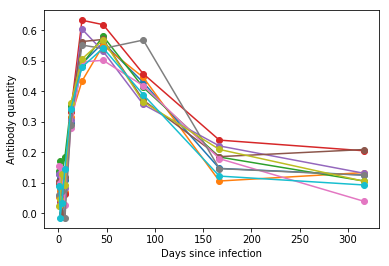

In [3]:
# Parameters for the antibody curve
theta = dict(X1=0.06, A=6, r=0.05, d=0.08, B=150, X2=0.07)
sigma = 0.05 # Standard deviation about the curve

time_points = np.logspace(0, 2.5, num=10)
num_hosts = 10
lab_data = [np.array([surv.antibody_dynamics(t, theta, sigma)[0] for t in time_points]) 
                        for i in range(num_hosts)]

fig, ax = plt.subplots(1, 1)
lines = ax.plot(time_points, np.array(lab_data).T, '-o')
ax.set_ylabel("Antibody quantity")
ax.set_xlabel("Days since infection")

Colored lines represent individual hosts antibody curves that were sampled through time. This is the **longitudinal** data that we use to parameterize the antibody curve.

### Fit the antibody curve to data

In [72]:
antibody_model = pystan.StanModel("stan_code/estimate_antibody_curve_constant_variance.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e342c32657c09b044e8c0c88749eb074 NOW.


In [490]:
flat_lab_data = np.concatenate(lab_data)
flat_time = np.tile(time_points, num_hosts)
standata = dict(N=len(flat_time), time=flat_time, antibody=flat_lab_data)
amod_fit = antibody_model.sampling(data=standata, iter=8000, warmup=4000, chains=2)

In [491]:
amod_fit

Inference for Stan model: anon_model_e342c32657c09b044e8c0c88749eb074.
2 chains, each with iter=8000; warmup=4000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=8000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X1      0.05  1.6e-4 9.6e-3   0.03   0.04   0.05   0.05   0.06   3823    1.0
A        5.7  8.9e-3    0.5   4.65   5.39   5.73   6.03   6.61   3178    1.0
r       0.05  8.3e-5 4.7e-3   0.04   0.05   0.05   0.05   0.06   3186    1.0
logB    4.98  2.1e-3   0.11   4.73   4.92    5.0   5.06   5.14   2557    1.0
d       0.08  1.9e-4   0.01   0.05   0.07   0.08   0.08    0.1   2787    1.0
X2      0.07  4.2e-4   0.02   0.03   0.06   0.07   0.09   0.11   2083    1.0
sigma   0.05  5.8e-5 3.8e-3   0.04   0.05   0.05   0.05   0.06   4327    1.0
B     146.49     0.3   15.2 113.49 136.53 148.53 157.96 170.67   2574    1.0
lp__  135.73    0.05   2.12  130.6 134.65  136.1 137.29 138.68   1527    1.0

Samples were drawn using NUTS at Mon Mar

In [492]:
# True curve vs. predicted curve
vals = np.linspace(0, 300, num=500)
pred_curves = []
for i in range(100):
    ttheta, _ = surv.extract_theta(amod_fit)
    pred_curves.append([surv.antibody_dynamics(t, ttheta, 0)[0] for t in vals])

Text(0.5,0,'Days since infection')

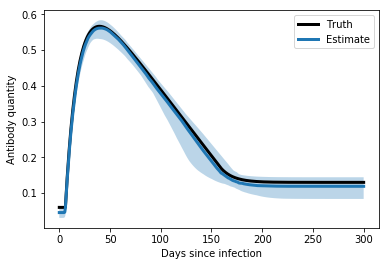

In [493]:
fig, ax = plt.subplots(1, 1)
true_ab = [surv.antibody_dynamics(t, theta, 0) for t in vals]
ax.plot(vals, true_ab, lw=3, color="black", label="Truth")
med_curve = np.median(np.array(pred_curves), axis=0)
lower_curve = stats.scoreatpercentile(np.array(pred_curves), 2.5, axis=0)
upper_curve = stats.scoreatpercentile(np.array(pred_curves), 97.5, axis=0)
ax.plot(vals, med_curve, lw=3, label="Estimate")
ax.fill_between(vals, lower_curve, upper_curve, alpha=0.3)
ax.legend()
ax.set_ylabel("Antibody quantity")
ax.set_xlabel("Days since infection")

Comparing the true antibody curve to the predicted antibody curve

## Combining the longitudinal lab data with cross-sectional field samples to estimate TOI

In [4]:
# Set up the field daata
start_month = 5
end_month = 4
start = pd.datetime(2015, start_month, 1)
end = pd.datetime(2016, end_month, 30)

inf_days = pd.date_range(start, end) # Range of days over which to sample hosts
vals = np.arange(0, 365)
num_pop = 10000 # Total pop size from which we are sampling
num_hosts = 500 # Number of hosts that were sampled

days = np.array([d.days for d in pd.to_datetime(inf_days) - start])

# Uniform sampling across time
unif = np.repeat(1 / (len(inf_days)), len(inf_days))

# Unimodal infection distribution
unimod = surv.weibull_sampling_probs(days, 3, 200)

# Sample hosts uniformly with unimodal infection risk over season
sero_df = surv.build_serology_data(inf_days, unimod, unif, 
                               num_hosts, theta, sigma, start,
                               total_pop=num_pop)

Text(0,0.5,'Number of hosts')

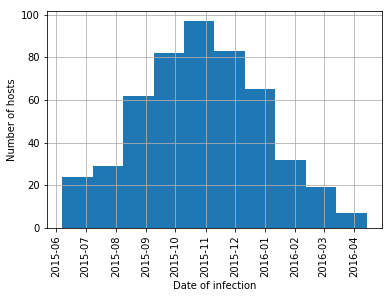

In [5]:
sero_df.true_toi.hist()
plt.tick_params(axis="x", rotation=90)
plt.xlabel("Date of infection")
plt.ylabel("Number of hosts")

In [497]:
# Assume no misclassification error of infected individuals
sero_df.loc[:, "infection"] = sero_df.sample_date >= sero_df.true_toi

# Build data for stan analysis
P = sero_df.infection.sum()

positive_ids = -1*np.ones(len(sero_df))
positive_ids[sero_df.infection] = np.arange(1, (P + 1))

standata_full = dict(P=P,
                     T=len(sero_df),
                     ab=sero_df.serodata.values,
                     positive=sero_df.infection.astype(np.int).values,
                     positive_id = positive_ids.astype(np.int))
standata_full.update(standata)

med_theta, _ = surv.extract_theta(amod_fit, parnames=['X2', 'B', 'X1', 'A', 'r', 'd', 'sigma'], median=True)
standata_full.update(med_theta)

In [429]:
# Model simultaneously fitting both longitudinal and cross-sectional data
#tsi_mod = pystan.StanModel("stan_code/estimate_TSI_with_longitudinal_and_crosssectional_data.stan")

# Model using the median parameter estimates from the antibody curve to estimate TSI.
# While not incorporating all uncertainty, this model tends to be more stable and still
# does a good job estimating infection risk.
tsi_mod = pystan.StanModel("stan_code/estimate_TSI_with_longitudinal_data.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_49bc7baf980c2ef6ac3216db4a18aad2 NOW.


In [498]:
# NOTE: If you don't supply initial values, this can take a bit to warm up. Be sure to check the diagnostics
# and to run multiple chains.
tsi_fit = tsi_mod.sampling(data=standata_full, iter=8000, warmup=4000, chains=2)

In [499]:
# Extract TSI max and min estimates
tsi_min, tsi_max, inds = surv.calc_tsi(tsi_fit, 200, fixed_params=med_theta)

Sample 10 of 267
Sample 20 of 267
Sample 30 of 267
Sample 40 of 267
Sample 50 of 267
Sample 60 of 267
Sample 70 of 267
Sample 80 of 267
Sample 90 of 267
Sample 100 of 267
Sample 110 of 267
Sample 120 of 267
Sample 130 of 267
Sample 140 of 267
Sample 150 of 267
Sample 160 of 267
Sample 170 of 267
Sample 180 of 267
Sample 190 of 267
Sample 200 of 267
Sample 210 of 267
Sample 220 of 267
Sample 230 of 267
Sample 240 of 267
Sample 250 of 267
Sample 260 of 267


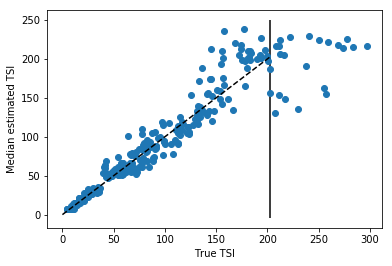

In [500]:
true_tsi = np.array([d.days for d in 
                     (sero_df[sero_df.infection].sample_date - sero_df[sero_df.infection].true_toi)])
med_tsi_max = stats.scoreatpercentile(tsi_max, 50, axis=0)
med_tsi_min = stats.scoreatpercentile(tsi_min, 50, axis=0)

# Time where antibody curve is maximized and where curve flattens out (tau_end)
maxg = surv.max_g(theta['A'], theta['r'], theta['B'], theta['d'], theta['X2'])
tau_end = surv.get_tau_end(theta)

# Assume we know whether an estimate came from the rising or falling arm of the curve
true_rising = true_tsi < maxg
est_tsi = np.empty(len(true_tsi))
est_tsi[true_rising] = med_tsi_min[true_rising]
est_tsi[~true_rising] = med_tsi_max[~true_rising]

plt.plot(true_tsi, est_tsi, 'o')
plt.vlines(tau_end, *plt.ylim())
plt.xlabel("True TSI")
plt.ylabel("Median estimated TSI")
x = np.linspace(0, tau_end, num=100)
plt.plot(x, x, '--', color="black")

The black dashed line is the 1:1 line where true and estimated TSI are the same. The black vertical line is the true value of $\tau_{\text{end}}$ to the right of which there are many TSI cannot be estimated because there are many TSIs corresponding to one antibody value. This is the flat portion of the falling arm on the antibody curve (see antibody curve above).  Values to the right of the black vertical line can be considered "left-censored" because a unique TSI cannot be estimated for them. 

## Using time of infection data to estimate seasonal infection risk

The scripts `age_analysis.py`, `rightcensored_analysis.py`, and `leftcensored_analysis.py` extensively illustrate how these TOI estimates can be used to infer seasonal infection risk. 

Here is a brief demonstration on how these TSI estimates can be combined with a left-censored survival analysis to estimate seasonal infection risk. 

In [501]:
# Calculate the time since infection
sero_df.loc[:, "toi"] = pd.NaT
inf = sero_df.infection

# Compute estimated TOI
sero_df.loc[inf, "toi"] = sero_df.loc[inf, "sample_date"] - pd.to_timedelta(est_tsi, unit="d")

# For unifected individuals just set TOI to after sampling date by default. Why? Just so surv.build_survival_data knows that 
# an individual with toi > sample_date is uninfected.
sero_df.loc[~inf, "toi"] = sero_df.loc[~inf, "sample_date"] + pd.Timedelta(1, unit="d")

# Build dataframe for survival analysis
surv_df = surv.build_survival_data(sero_df, pd.Timestamp(start))

# Not considering recovery
recovered = np.repeat(0, len(surv_df))

# Identify the hosts that are left-censored. Any hosts with a true time since infection > tau_end. Other criteria could be
# used
leftcensored = surv_df.index.isin(surv_df[inf].iloc[np.where(true_tsi > tau_end)[0], :].index).astype(np.int)

In [502]:
# Build the parametric spline data for the seasonal infection risk analysis. This function performs all of the
# spline calculations to fit the flexible parametric model.
data_for_seasonal = surv.build_parametric_data(surv_df, recovered, leftcensored, theta, pd.Timestamp(start), df=4)

In [ ]:
lc_mod = pystan.StanModel("stan_code/infectionrisk_leftcensored.stan")

In [503]:
risk_fit = lc_mod.sampling(data=data_for_seasonal, iter=4000, warmup=2000, chains=2)

In [481]:
risk_fit

Inference for Stan model: anon_model_2f56f50042abcd157f68496e6ac7e853.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept  -6.72    0.01   0.54  -7.81  -7.09   -6.7  -6.34  -5.69   1369    1.0
betas[1]    5.14    0.02   0.81   3.53   4.57   5.17   5.69   6.66   1241    1.0
betas[2]    6.04    0.01   0.52   5.07   5.68   6.01   6.39   7.11   1638    1.0
betas[3]    8.25    0.02   0.56   7.19   7.87   8.25   8.64   9.36   1323    1.0
tau         1.48  9.7e-3   0.44   0.82   1.15   1.41   1.73   2.47   2071    1.0
lp__      -139.7    0.04   1.58 -143.8 -140.5 -139.4 -138.5 -137.6   1423    1.0

Samples were drawn using NUTS at Mon Mar  4 15:07:47 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

### Extract the seasonal infection risk estimates and plot the results

In [504]:
# Extract the seasonal infection risk estimates
time = surv_df.time_in_season.values
curves = surv.extract_fit(risk_fit, time, df=4)

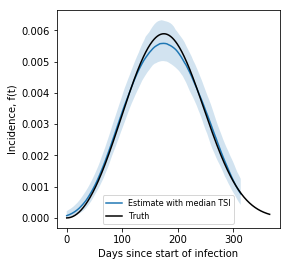

In [505]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

med_f = np.exp(stats.scoreatpercentile(curves['logfdensity'], 50, axis=0)) / np.max(time)
lower_f = np.exp(stats.scoreatpercentile(curves['logfdensity'], 2.5, axis=0)) / np.max(time) 
upper_f = np.exp(stats.scoreatpercentile(curves['logfdensity'], 97.5, axis=0)) / np.max(time)

ax.plot(curves['newtime'], med_f, label="Estimate with median TSI")
ax.fill_between(curves['newtime'], lower_f, upper_f, alpha=0.2)
ax.plot(days, unimod, color="black", label="Truth")

#ax.legend(loc="upper right", prop={'size': 7})
ax.set_xlabel("Days since start of infection")
ax.set_ylabel("Incidence, f(t)")
ax.legend(prop={'size': 8})

The estimate of seasonal infection risk is pretty good even when a number of the TSI estimates deviate from the true tsi estimates (see plot above). In the corresponding manuscript, we assume that TOI estimates are known and show that the approach we develop for estimating infection risk can recover true infection risk under a range of different seasonal sampling and infection distributions.